### Guided Project #9. Popular Data Science Questions
Exploring Data Science Stack Exchange

#### 1. Stack Exchange Data Explorer
Looking at Stack Exchange Data Explorer,
https://data.stackexchange.com/datascience/query/new

The Posts table seem to have a Score field which should be a good measurement of post's popularity

#### 2. Runing a query against the SEDE DSSE database

The queary should extract the columns listed below for all the questions in 2020.
- Id: An identification number for the post.
- PostTypeId: An identification number for the type of post. 
    -  1 - Question
    -  2 - Answer
- CreationDate: The date and time of creation of the post.
- Score: The post's score.
- ViewCount: How many times the post was viewed.
- Tags: What tags were used.
- AnswerCount: How many answers the question got (only applicable to question posts).
- FavoriteCount: How many times the question was favored (only applicable to question posts).

```SQL
SELECT Id, 
    PostTypeId, 
    CreationDate, 
    Score, 
    ViewCount, 
    Tags, 
    AnswerCount, 
    FavoriteCount
    FROM Posts
    WHERE CreationDate BETWEEN '20200101' AND '20201231'
    AND PostTypeId = 1
```

The result of the queary was downloaded as 2020_Questions.csv

#### 3. Reading the data into DataFrame
Reading the data into pandas DF and cleaning up

In [21]:
import pandas as pd

questions = pd.read_csv('2020_Questions.csv', parse_dates = ['CreationDate'])

questions.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,66520,1,2020-01-15 13:54:37,2,91,<machine-learning><statistics><recommender-sys...,0,1.0
1,66521,1,2020-01-15 14:02:33,1,190,<machine-learning><xgboost><word-embeddings><c...,3,NaN
2,66524,1,2020-01-15 14:55:09,9,586,<machine-learning><feature-selection><decision...,2,2.0
3,66526,1,2020-01-15 16:37:47,1,22,<deep-learning><cnn><optimization>,0,NaN
4,66527,1,2020-01-15 17:52:45,1,33,<image>,1,NaN


In [22]:
print(questions.shape)
questions.info()

(7562, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7562 entries, 0 to 7561
Data columns (total 8 columns):
Id               7562 non-null int64
PostTypeId       7562 non-null int64
CreationDate     7562 non-null datetime64[ns]
Score            7562 non-null int64
ViewCount        7562 non-null int64
Tags             7562 non-null object
AnswerCount      7562 non-null int64
FavoriteCount    934 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 472.7+ KB


In [23]:
questions.fillna(0, inplace = True)
questions['ViewCount'] = questions['ViewCount'].astype(int)
questions['AnswerCount'] = questions['AnswerCount'].astype(int)
questions['FavoriteCount'] = questions['FavoriteCount'].astype(int)
questions['Tags'] = questions['Tags'].str.replace('><',',').str.replace('<','').str.replace('>','')
questions.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,66520,1,2020-01-15 13:54:37,2,91,"machine-learning,statistics,recommender-system",0,1
1,66521,1,2020-01-15 14:02:33,1,190,"machine-learning,xgboost,word-embeddings,categ...",3,0
2,66524,1,2020-01-15 14:55:09,9,586,"machine-learning,feature-selection,decision-tr...",2,2
3,66526,1,2020-01-15 16:37:47,1,22,"deep-learning,cnn,optimization",0,0
4,66527,1,2020-01-15 17:52:45,1,33,image,1,0


In [24]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7562 entries, 0 to 7561
Data columns (total 8 columns):
Id               7562 non-null int64
PostTypeId       7562 non-null int64
CreationDate     7562 non-null datetime64[ns]
Score            7562 non-null int64
ViewCount        7562 non-null int64
Tags             7562 non-null object
AnswerCount      7562 non-null int64
FavoriteCount    7562 non-null int64
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 472.7+ KB


### 4. Determining the most popular tags

#### 4.1. How many times each tag was used

In [76]:
tags_list = list(questions['Tags'].str.split(',')) # list of lists
tags = set()
for tags_row in tags_list:
    tags.update(tags_row)
    
tags = list(tags)

tags_df = pd.DataFrame(index=tags)

for tag in tags:
    mask = questions['Tags'].str.split(',').apply(lambda x: tag in x)
    tags_df.loc[tag,'Used'] = questions[mask].shape[0]
    
tags_df.head()

,Used
probability,76.0
time-series,398.0
gradient-descent,130.0
information-retrieval,18.0
experiments,9.0


#### 4.2. How many times each tag was viewed

In [77]:
for tag in tags:
    mask = questions['Tags'].str.split(',').apply(lambda x: tag in x)
    tags_df.loc[tag,'Viewed'] = questions[mask]['ViewCount'].sum()
    
tags_df.head()

,Used,Viewed
probability,76.0,4506.0
time-series,398.0,31650.0
gradient-descent,130.0,18142.0
information-retrieval,18.0,908.0
experiments,9.0,227.0


In [78]:
tags_df['Used'] = tags_df['Used'].astype(int)
tags_df['Viewed'] = tags_df['Viewed'].astype(int)
tags_df.head()

,Used,Viewed
probability,76,4506
time-series,398,31650
gradient-descent,130,18142
information-retrieval,18,908
experiments,9,227


#### 4.3. Top tags visualizations

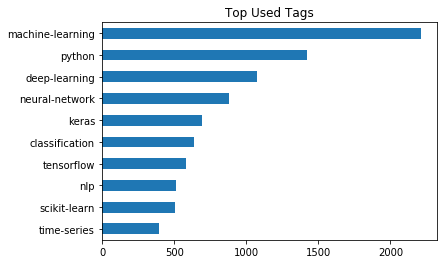

In [90]:
top_used = tags_df['Used'].sort_values(ascending=False).head(10)
top_used.sort_values().plot(kind='barh', title='Top Used Tags')

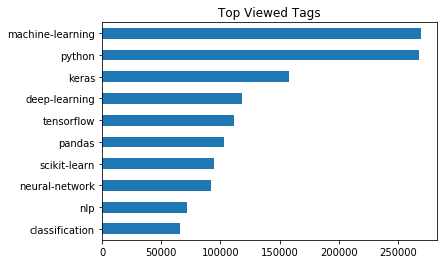

In [91]:
top_viewed = tags_df['Viewed'].sort_values(ascending=False).head(10)
top_viewed.sort_values().plot(kind='barh', title='Top Viewed Tags')

#### 5. Tag popularity over time
In this chapter we will track the interest in deep learning across time. 

The result of the following query to SEDE downloaded as All_Questoins.csv
```SQL 
SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;
```

In [97]:
all_q = pd.read_csv('All_Questions.csv', parse_dates=['CreationDate'])
all_q['Tags'] = all_q['Tags'].str.replace('><',',').str.replace('<','').str.replace('>','').str.split(',')
all_q.head()

,Id,CreationDate,Tags
0,36401,2018-08-03 02:08:47,"[neural-network, tensorflow, ensemble]"
1,36403,2018-08-03 03:53:25,[tensorflow]
2,36404,2018-08-03 05:01:01,"[machine-learning, feature-selection, data-sci..."
3,36406,2018-08-03 05:36:44,"[data-mining, predictive-modeling, correlation]"
4,36407,2018-08-03 06:08:33,"[keras, cnn]"


In [133]:
all_q['yearmon'] = all_q['CreationDate'].dt.year*100 + all_q['CreationDate'].dt.month
all_q.head()

,Id,CreationDate,Tags,yearmon,DeepLearning,year
0,36401,2018-08-03 02:08:47,"[neural-network, tensorflow, ensemble]",201808,False,2018
1,36403,2018-08-03 03:53:25,[tensorflow],201808,False,2018
2,36404,2018-08-03 05:01:01,"[machine-learning, feature-selection, data-sci...",201808,False,2018
3,36406,2018-08-03 05:36:44,"[data-mining, predictive-modeling, correlation]",201808,False,2018
4,36407,2018-08-03 06:08:33,"[keras, cnn]",201808,False,2018


In [134]:
all_q['DeepLearning']=all_q['Tags'].apply(lambda tags: 'deep-learning' in tags)
all_q.head()

,Id,CreationDate,Tags,yearmon,DeepLearning,year
0,36401,2018-08-03 02:08:47,"[neural-network, tensorflow, ensemble]",201808,False,2018
1,36403,2018-08-03 03:53:25,[tensorflow],201808,False,2018
2,36404,2018-08-03 05:01:01,"[machine-learning, feature-selection, data-sci...",201808,False,2018
3,36406,2018-08-03 05:36:44,"[data-mining, predictive-modeling, correlation]",201808,False,2018
4,36407,2018-08-03 06:08:33,"[keras, cnn]",201808,False,2018


In [135]:
dl_time = all_q.groupby('yearmon').sum()['DeepLearning']
dl_time.head()

yearmon
201405    0.0
201406    1.0
201407    1.0
201408    0.0
201409    0.0
Name: DeepLearning, dtype: float64

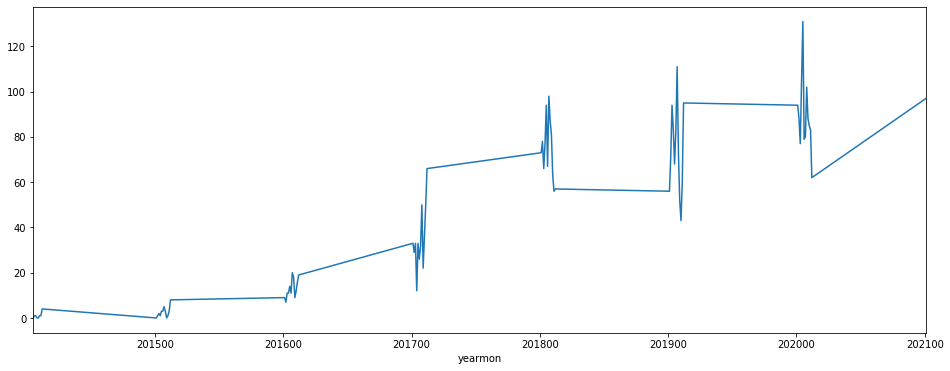

In [136]:
dl_time.plot(figsize=(16,6))

#### The chart looks wierd, because yearmon is of type Integer

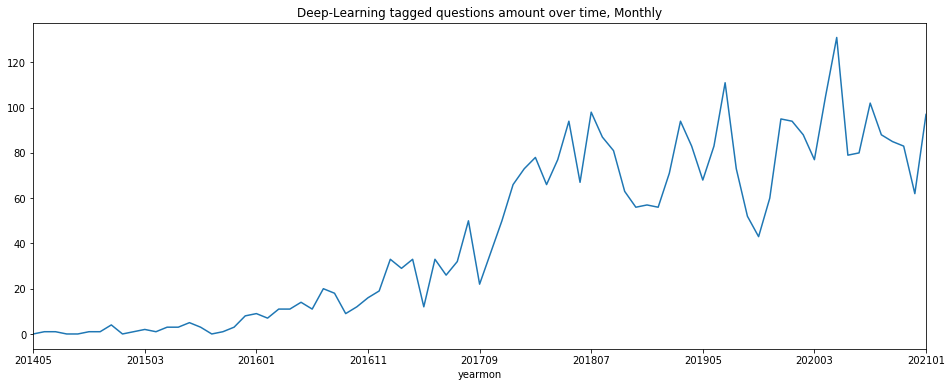

In [137]:
# Let's convert it to a String and redraw
dl_time.index = dl_time.index.astype(str)
dl_time.plot(figsize=(16,6), title='Deep-Learning tagged questions amount over time, Monthly')

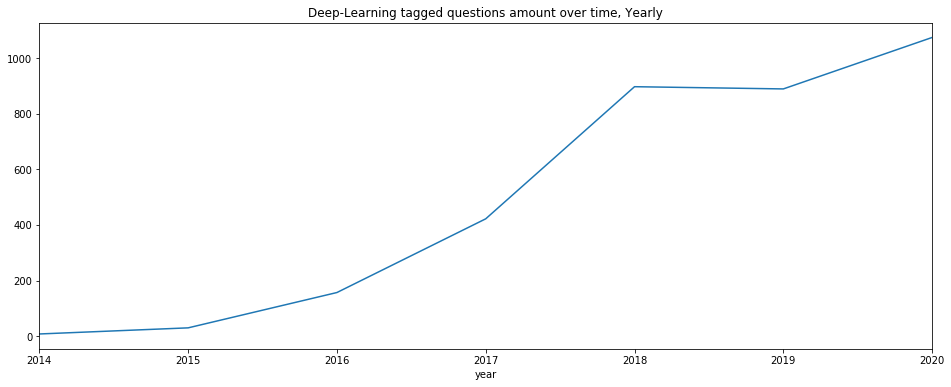

In [138]:
# Let's see how it looks like with year resolution as opposed to a month
all_q['year'] = all_q['CreationDate'].dt.year
dl_year = all_q[all_q['year']!=2021].groupby('year').sum()['DeepLearning']
dl_year.plot(figsize=(16,6), title='Deep-Learning tagged questions amount over time, Yearly')

In [139]:
dl_time.shape

(81,)